# Mid-level GP for Image denoising.

This notebook presents a demo on mezzanine primitives, applied in a real life scenario. We use the same target task from the previous example notebook (image filtering), we use the same dataset, and most of the GP hyperparameters remain the same. In fact, most of the notebook contains the exact same definitions as in the previous example, except for two important, but subtle, changes:

- we use the same kind of individual (NonConvFilter) but as defined in a different file (NonConvolutionalMezzanineFilter.py). This individual class defines a protected_crossover operation capable of handling mezzanine primitives; i.e., its crossover method contains the necessary logic to guarantee that gramatically valid offspring will always be generated (e.g., avoids connecting trimmers to low-level nodes).

- as such, in the section where we declare the primitives to use, mezzanine set is now enabled, as well as a set of trimmers defined.

For a detailed explanation on different types of primitives, please refer to [1].

`1. Rodriguez-Coayahuitl, L., Morales-Reyes, A., & Escalante, H. J. (2019, November). A Comparison among Different Levels of Abstraction in Genetic Programming. In 2019 IEEE International Autumn Meeting on Power, Electronics and Computing (ROPEC) (pp. 1-6). IEEE.`

In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'                         # For Intel Math Kernel Library
#os.environ['OPENBLAS_NUM_THREADS'] = '1'                   # For OpenBLAS

# if unsure which one you are using, type this command in a python terminal, after importing numpy.
#numpy.__config__.show()      

Usual library declaration part

In [2]:
%matplotlib notebook

# Required Python libraries
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from networkx.drawing.nx_agraph import graphviz_layout

# TurboGP libraries
from GPIndividuals import *      
from GPOperators import *        
from GPflavors import *          
from LowLevel import *           
from Mezzanine import *          
from HighLevel import *          
from Trimmers import *           
from GPUtils import *            
from Utils import *              

# This is useful for when there is overflow, so output cells do not fill with warning messages.
# Disable to debug
import warnings
warnings.simplefilter('ignore')

Extra libraries for image filtering:

In [3]:
from six.moves import cPickle as pickle                 # To load the dataset we will be using

from NonConvolutionalMezzanineFilter import *           # This is the GP individual we will use.

from matplotlib.colors import Normalize                 # To plot image patches

Notice how we imported the individual class from a different file: NonConvolutionalMezzanineFilter. As explained at the top of this notebook, this variant of the NonConvFilter individual is capable of performing crossovers taking into account mezzanine-level primitives and trimmers.

Load the dataset:

In [4]:
# Load file
f = np.load('bsds50-21x21-mini.npz', allow_pickle=True)

# Load images only
x_training = f['x_train_50']
y_training = f['y_residual_50']

# What they look like? (in an array sense)
print(x_training.shape)
print(y_training.shape)

(14000, 21, 21)
(14000, 21, 21)


14,000 samples, of 21x21 grayscale pixels. We will use 12,000 for training purposes and 2,000 as testing dataset:

In [5]:
x_train = x_training[0:12000]
y_train = y_training[0:12000]

batchesX = x_train.reshape(60, 200, 21, 21)
batchesY = y_train.reshape(60, 200, 21, 21)

x_test = x_training[12000:14000]
y_test = y_training[12000:14000]

Things changes a little bit up here. Notice how we made the mini-batches smaller in size (200 samples instead of 300). This is because mezzanine operations, due to their very nature, are more expensive to carry out; i.e. an individual with mezzanine nodes will take more time to evaluate than an individual with low-level only nodes, given the same number of nodes. So, the size of the minibatches is reduced to compensate this overhead. We will also be using less epochs/generations, so the time given to both algorithms remains comparable. Nevertheless, even in these circumstances, MidGPs will, more often than not, outperform Low-Level GPs

Let's pick the set of primitives we would like to use to tackle this problem. This is where things change considerably; mezzanine set now contains some functions:

In [6]:
# Each of these functions must be properly defined in the corresponding python modules.
lowlevel = ['ADD', 'SUB', 'MUL', 'DIV', 'RELU', 'MAX', 'MEAN', 'MIN', 'X2', 'SIN', 'COS', 'SQRT']
mezzanine = ['mMEAN', 'mSTD', 'mMAX', 'mMIN', 'mMED']
highlevel = None


# Now we let the Node objects know the set of input based primitives available at each layer.
Node.f1_set=lowlevel
Node.f2_set=mezzanine
Node.f3_set=highlevel

# This is the range of constants leaf nodes can take a value from (when not taking the form of a input variable)
Node.i2_set=[-1.0,1.0]

In order to use mezzanine functions, we also need to define Trimmers. In this example scenario, trimmers can be things such as 3x3 center area of the patch, the borders of the patch (Outer Ring), top left quarter corner (NorW), etc.

In [7]:
trimmers = ['TFull', 'TNorW', 'TNorE', 'TSouW', 'TSouE', 'TCenter3', 'TCenter5', 'TOuterR']

Node.i3_set = trimmers

The rest of the GP hyperparameters remain the same as in the previous example.

In [8]:
pop_size = 1000                                  # Population size

oper = [NonConvFilter.mutation,                  # Genetic operations to use.
        NonConvFilter.protected_crossover]       # notice how they are defined by the type of individual we will evolve

oper_prob = [.5, .5]                             # Probabity of each GP operation (in the same order as declared above)
oper_arity = [1, 2]                              # How many parents required by each operation.

l_rate = 1.0                                     # Offspring pool size, defined as the ratio to the population size.

minimization = True                              # if it is a minimization problem or not
sel_mechanism = binary_tournament                # Preferred selection mechanism for parent selection

Now let's create the initial population. The name of the individual class is the same (but taken from a different file); there is however, one additional parameter: high_depth_allocation. High depth allocation specifies what portion of the tree should be reserved exclusively for low-level nodes. If this provision is not taken into consideration, mezzanine nodes may appear too close to the root; our intention is to use mezzanine-trimmers as feature extraction stages, while relying to low-level nodes for fine processing (regression/prediction stage).

We will set high_depth_allocation = .5, which offers a good balance between low-level nodes allocation and mezzanine leaf nodes (higher value will allow mezzanine functions too close to the root, while smaller value will fill the trees with almost low-level nodes exclusively).

Note that this applies for when creating the initial population, or when performing subtree mutations; crossover might still put mezzanine nodes very close to the root, independently of this parameter.

In [9]:
%%time
Population = []

for _ in range(pop_size):
        Population.append(NonConvFilter(lateral_window_size = 21, complexity = 9, high_depth_allocation = .5))

CPU times: user 772 ms, sys: 16 ms, total: 788 ms
Wall time: 769 ms


Let's see how long does it take to evaluate the entire population on a single mini-batch.

In [10]:
%%time
#initial evaluation
for individual in Population:
    individual.fitness(batchesX[-1], batchesY[-1])


CPU times: user 8.81 s, sys: 12 ms, total: 8.82 s
Wall time: 8.82 s


As we can see, even though mini-batches are smaller, the evaluation of the population took more time than when trees were composed of low-level nodes only. So, in order to give the same amount of runtime to both versions of the algorithm, we will also need to decrease the number of epochs/generations to elapse:

In [11]:
# Set number of epochs:
epochs = 1

no_batches = len(batchesX)
Generations = no_batches * epochs

# Lists for storing statistics:
diversity = []
fitness = []
test_fitness = []

Run evolutionary cycles:

<IPython.core.display.Javascript object>


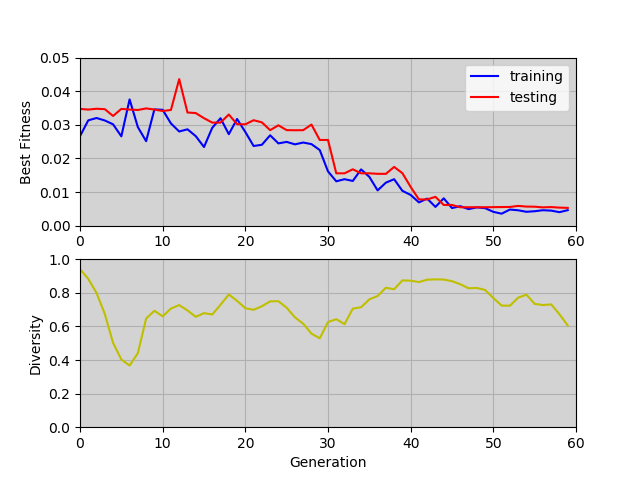

100%|██████████| 60/60 [09:15<00:00,  9.26s/it]


In [12]:
############################################################################################################
# The following piece of code, will allow us to display -in real time- the progress of training fitness,   #
# testing fitness and diversity decay. It is a bit overcomplicated, and it is optional of course, but it   #
# is very useful to understand and visualize if the GP is achieving convergence.                           #

x = list(range(Generations))                                                                               #

y = np.empty(Generations)                                                                                  #
y[:]=np.nan                                                                                                #
y2 = np.empty(Generations)                                                                                 #
y2[:]=np.nan                                                                                               #
d3 = np.empty(Generations)                                                                                 #
d3[:]=np.nan                                                                                               #

plt.ion()                                                                                                  #
fig = plt.figure()                                                                                         #
ax = fig.add_subplot(211)                                                                                  # 
ax.set_ylabel('Best Fitness')                                                                              #
ax.set_ylim(0.0,0.05)                                                                                       #
ax.set_xlim(0,Generations)                                                                                 #
ax.set_facecolor('lightgray')                                                                              #  
ax.grid(True)                                                                                              #
ax2 = fig.add_subplot(212)                                                                                 #
ax2.set_xlabel('Generation')                                                                               #
ax2.set_ylabel('Diversity')                                                                                #
ax2.set_ylim(0.0,1.0)                                                                                      #
ax2.set_xlim(0,Generations)                                                                                #
ax2.set_facecolor('lightgray')                                                                             #
ax2.grid(True)                                                                                             #

line1, = ax.plot(x, y, 'b-', label='training')                                                             #
line2, = ax.plot(x, y2, 'r-', label='testing')                                                             #
line3, = ax2.plot(x, d3, 'y-')                                                                             #
ax.legend()                                                                                                #
############################################################################################################

pbar = tqdm.tqdm(total=Generations)                        

i = 0                          
for e in range(epochs):
    
    for j in range(no_batches):
        
        Population, d, bf, tf = Steady_StateMP(Population = Population,
                                               batch = batchesX[j],           
                                               labels = batchesY[j],
                                               test_batch = x_test,
                                               test_labels = y_test,
                                               l_rate = l_rate,
                                               oper = oper,
                                               oper_prob = oper_prob,
                                               oper_arity = oper_arity,
                                               minimization = minimization,
                                               sel_mechanism = sel_mechanism,
                                               online = True,
                                               pro = 4)             # Everything is the same as in previous example
                                                                    # except for the name of the function we are 
                                                                    # calling, and this last parameter that indicates
                                                                    # how many CPUs/threads we want to use.
        
        diversity.append(d)
        fitness.append(bf)
        test_fitness.append(tf)

        # For live plotting #################
        y[i]=fitness[i]
        y2[i]=test_fitness[i]
        d3[i]=diversity[i]

        line1.set_ydata(y)
        line2.set_ydata(y2)
        line3.set_ydata(d3)

        fig.canvas.draw()
        #####################################
        
        i += 1
        pbar.update(1)      
    
pbar.close()

As we can see, even with less generations, and less computational time (less time in the same number of cores on the same CPU), MidGP outclass LowGP.
Let's see the best scores obtained:

In [13]:
print("Training fitness of best individual found: ", fitness[-1])
print("Testing  fitness of best individual found: ", test_fitness[-1])

Training fitness of best individual found:  0.004595541600087153
Testing  fitness of best individual found:  0.005271351038857238


Results above are expressed in MSE.

Let's get the best individual found:

In [14]:
solver = elite_selection(population=Population, amount=1, minimization=minimization)[0]

and see what it looks like:

<IPython.core.display.Javascript object>


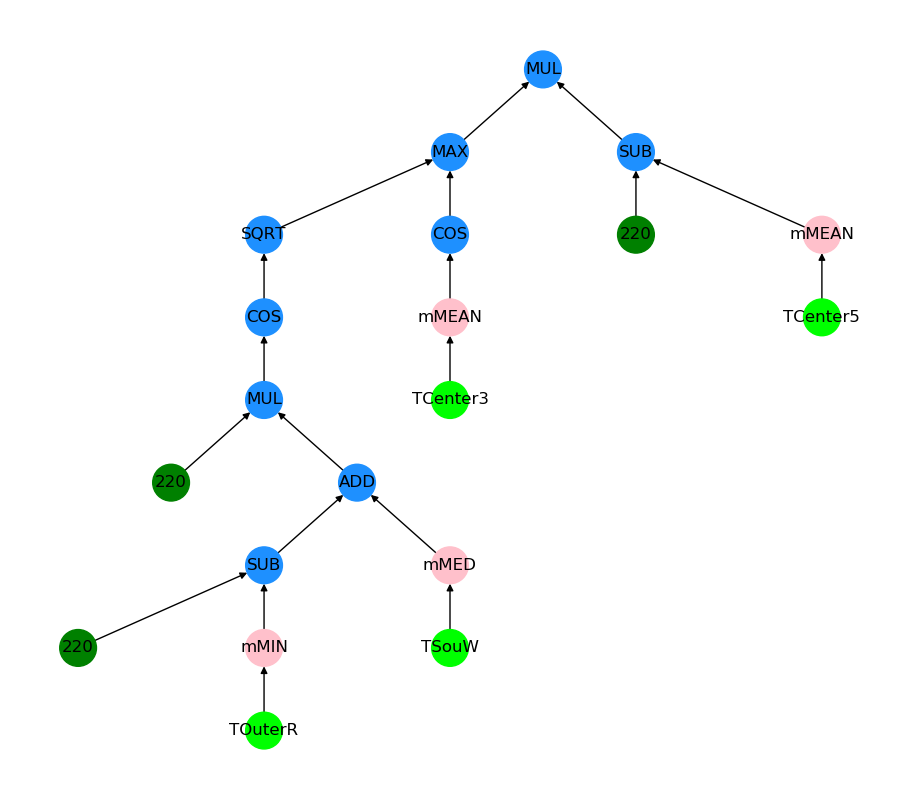

In [15]:
plt.figure(figsize=(9,8))
graph, labels, color_map = get_graph(solver.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=700, node_color=color_map)

We can see that the model generated relies heavily on mezzanine functions, but it also depends on pixel 220, which is precisely the center pixel of the patch (the pixel which we train the model to predict its noise level).

Now let's use the model in the same image patches as in the previous example, so we can qualitatively compare the performance of both models.

In [16]:
decoded_imgs = []

for x in range (10):
    noise_mask = solver.predict(x_training[x])
    reconstruction = x_training[x] - noise_mask
    decoded_imgs.append(reconstruction)

Lets pull from the dataset the clean, original, versions of the patches:

In [17]:
y_label = f['y_train']

Plot them. First row, original; next, noisy; last row, GP reconstructions.

<IPython.core.display.Javascript object>


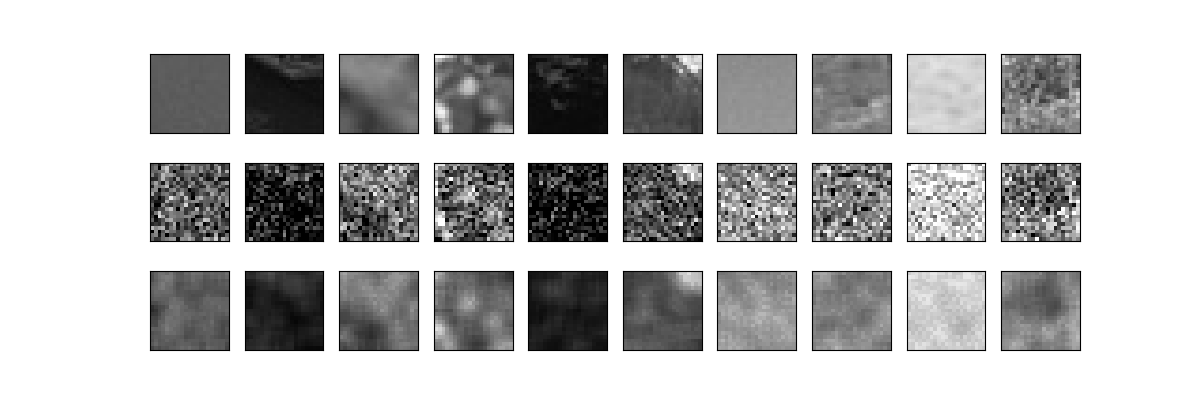

In [18]:
norm = Normalize(vmin=0, vmax=1, clip=True)

n = 10  # how many digits we will display
plt.figure(figsize=(12, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(y_label[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_training[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.imshow(decoded_imgs[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The results generated by this model are different from those obtained by the LowGP. The filtered images are smoother; and while it visualy performs worst in texturized surfaces (which look washed out), in plain surfaces its performance is noticeable better.